# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета. 

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


## Работа с датасетом  Image Colorization  https://www.kaggle.com/datasets/shravankumar9892/image-colorization

In [1]:
from tensorflow import keras
from keras.layers import Conv2D, UpSampling2D, Input, Conv2DTranspose, Dense,Flatten,Reshape,BatchNormalization,concatenate, MaxPooling2D, RepeatVector
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
import os
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import pandas as pd

In [14]:
#датасет Image Colorization 
# количество изображений : 25k
# Размер 224x224 
#формат хранения : npy (бинарные файлы формата питон)
images_gray = np.load("./archive/l/gray_scale.npy")
ab1 = np.load("./archive/ab/ab/ab1.npy")
ab2 = np.load("./archive/ab/ab/ab2.npy")
ab3 = np.load("./archive/ab/ab/ab3.npy")
ab  = np.concatenate((ab1, ab2,ab3), axis=0)


In [2]:
# Восстановление изображения RGB с использованием L и AB из набора данных
def LAB_to_RGB(image_gray,image_lab):

    

    # Инициализация нулями 
    img = np.zeros((224, 224, 3))
    img[:, :, 0] = image_gray
    img[:, :, 1:] = image_lab

    # Изменение типа данных массива img на 'uint8'
    img = img.astype('uint8')


    img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

    fig = plt.figure()
    f, ax = plt.subplots(1,2) 
    ax[0].imshow(image_gray, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow (img_)
    plt.show()


<Figure size 640x480 with 0 Axes>

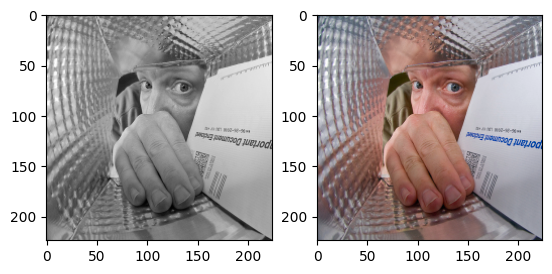

<Figure size 640x480 with 0 Axes>

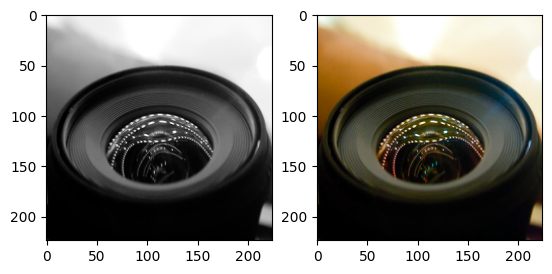

<Figure size 640x480 with 0 Axes>

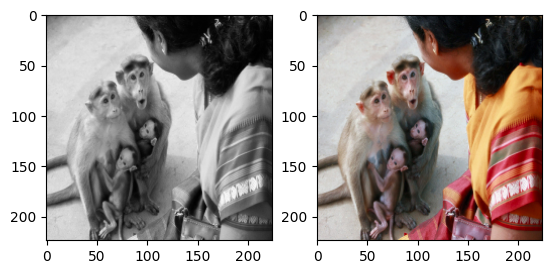

In [5]:
#пример пары данных. Данные довольно разнообразны - от людей до окружаюзего мира
LAB_to_RGB(images_gray[4],ab1[4])
LAB_to_RGB(images_gray[11505],ab2[1505])
LAB_to_RGB(images_gray[20500],ab3[500])


ab1 = None
ab2 = None
an3 = None

## Подготовка модели для обучения

In [80]:
#Encoder
encoder_input = Input(shape=(224, 224, 3))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)

model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 112, 112, 64)      1792      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 56, 56, 128)       147584    
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 256)       590080    
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 512)       1180

In [7]:
class DataGenerator_npy(tf.keras.utils.Sequence):

   def __init__(self, x_npy, y_npy, batch_size: int=16):
       self.X = np.load(x_npy)
       self.X =  np.stack((self.X,)*3, axis=-1)
       self.Y = np.load(y_npy)
       self.batch_size = batch_size


   def __len__(self):
       return int (len(self.X) / self.batch_size)

      
   def __getitem__(self, index):
         batch_l = self.X[index * self.batch_size : (index + 1) * self.batch_size]
         batch_ab = self.Y[index * self.batch_size : (index + 1) * self.batch_size]

         return batch_l, batch_ab

In [8]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

train_generator =  DataGenerator_npy('x_val.npy','y_val.npy')

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.0001)

filepath = "Color_Model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]

In [9]:

model.fit(train_generator, epochs=10,verbose=1, callbacks=model_callbacks)


Epoch 1/10
312/312 [==============================] - 63s 143ms/step - loss: 0.0712 - accuracy: 0.5258
Epoch 2/10
312/312 [==============================] - 37s 117ms/step - loss: 0.0455 - accuracy: 0.5279
Epoch 3/10
312/312 [==============================] - 39s 126ms/step - loss: 0.0450 - accuracy: 0.5292
Epoch 4/10
312/312 [==============================] - 39s 124ms/step - loss: 0.0444 - accuracy: 0.5303
Epoch 5/10
312/312 [==============================] - 38s 120ms/step - loss: 0.0448 - accuracy: 0.5384
Epoch 6/10
312/312 [==============================] - 39s 123ms/step - loss: 0.0444 - accuracy: 0.5380
Epoch 7/10
312/312 [==============================] - 40s 129ms/step - loss: 0.0444 - accuracy: 0.5403

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/10
312/312 [==============================] - 40s 128ms/step - loss: 0.0437 - accuracy: 0.5427
Epoch 9/10
312/312 [==============================] - 38s 121ms/step - loss: 0.0436 - accuracy:

In [161]:
def LAB_to_RGB_predict(image_gray,image_lab,model):

    img = np.zeros((224, 224, 3))
    img_pred = np.zeros((224, 224, 3))
        
    x =  np.stack((image_gray,)*3, axis=-1)
    x = x.reshape((1,224,224,3))
    pred_ab = model.predict(x)

    img[:, :, 0] = image_gray
    img[:, :, 1:] =  image_lab

    img_pred[:, :, 0] = image_gray
    img_pred[:, :, 1:] =  pred_ab*180

        # Изменение типа данных массива img на 'uint8'
    img = img.astype('uint8')
    img_pred = img_pred.astype('uint8')


    img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    img_pred_ =cv2.cvtColor(img_pred, cv2.COLOR_LAB2RGB)

    fig = plt.figure()
    f, ax = plt.subplots(1,3) 
    ax[0].imshow(image_gray, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow (img_)
    ax[2].imshow (img_pred_)
    plt.show()

<Figure size 640x480 with 0 Axes>

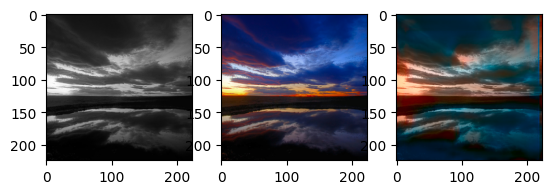

<Figure size 640x480 with 0 Axes>

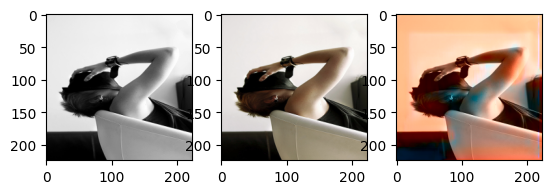

<Figure size 640x480 with 0 Axes>

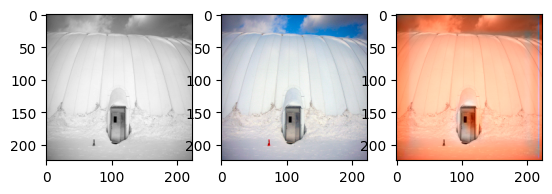

In [162]:
LAB_to_RGB_predict(images_gray[-50],ab3[-50],model)
LAB_to_RGB_predict(images_gray[189],ab1[189],model)
LAB_to_RGB_predict(images_gray[-127],ab3[-127],model)


# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [2]:
from skimage.io import imread, imsave
from block_distortion import distort_image
import os 
from os import walk
import cv2

import skimage.util as img_as_ubyte
from sklearn.model_selection import train_test_split
from imutils import paths

In [3]:

mypath = './2/pickachu/'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

print(f)


['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '000100.jpg', '0001000.jpg', '0001001.jpg', '0001002.jpg', '0001003.jpg', '0001004.jpg', '0001005.jpg', '0001006.jpg', '0001007.jpg', '0001008.jpg', '0001009.jpg', '000101.jpg', '0001010.jpg', '0001011.jpg', '0001012.jpg', '0001013.jpg', '0001014.jpg', '0001015.jpg', '000102.jpg', '000103.jpg', '000104.jpg', '000105.jpg', '000106.jpg', '000107.jpg', '000108.jpg', '000109.jpg', '00011.jpg', '000110.jpg', '000111.jpg', '000112.jpg', '000113.jpg', '000114.jpg', '000115.jpg', '000116.jpg', '000117.jpg', '000118.jpg', '000119.jpg', '00012.jpg', '000120.jpg', '000121.jpg', '000122.jpg', '000123.jpg', '000124.jpg', '000125.jpg', '000126.jpg', '000127.jpg', '000128.jpg', '000129.jpg', '00013.jpg', '000130.jpg', '000131.jpg', '000132.jpg', '000133.jpg', '000134.jpg', '000135.jpg', '000136.jpg', '000137.jpg', '000138.jpg', '000139.jpg', '00014.jpg', '000140.jpg', '00

Применение блочной дисторсии и сохранение данных

In [ ]:
q = 0
for i in f:
    input_image = imread(mypath+i)
    q = q + 1
    input_image.shape
    # distort the read image

    distorted = distort_image(input_image)
    # save to required path the converted binary image
    imsave("1_dis.png", distorted)
    img_png =cv2.imread('1_dis.png')
    cv2.imwrite('./dis/{}.jpg'.format(i),img_png, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

In [44]:
from  keras.layers import Concatenate

input = Input(shape=(224, 224, 3)) 

e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input)
pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
batchnorm_1 = BatchNormalization()(pool1)

e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
batchnorm_2 = BatchNormalization()(pool2)

e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
h = MaxPooling2D((2, 2), padding='same')(e_conv3)

d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(d_conv1)

d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(d_conv2)


d_conv3 = Conv2D(16, (3, 3), activation='relu',padding='same')(up2)
up3 = UpSampling2D((2, 2))(d_conv3)
    
r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(input, r)
autoencoder.compile(optimizer=Adam(learning_rate=0.00001), loss=['binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 56, 56, 32)        128 

Загрузка изображений

In [5]:
x = []
y = []
f = []


for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

for filename in filenames:
    image = cv2.imread('./2/dis/{}.jpg'.format(filename)) # загружаем изображение
    image = cv2.resize(image, (224, 224))

    x.append(image)
    image_1 = cv2.imread('./2/pickachu/{}'.format(filename))
    image_1 = cv2.resize(image_1, (224, 224)) 

    y.append(image_1)

x = np.array(x, dtype="float") / 255.0
y = np.array(y, dtype="float") / 255.0


In [6]:
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.25, random_state=42)


print('Train: X = ', x_train.shape)
print('Test: X = ', x_test.shape)

Train: X =  (753, 224, 224, 3)
Test: X =  (251, 224, 224, 3)


Обучение модели

In [7]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.0001)

filepath = "Dis_model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]


In [46]:
history = autoencoder.fit(x_train, y_train, 
epochs=50,
batch_size= 8, 
validation_data = (x_test,y_test),
verbose=1,
callbacks = model_callbacks)

Epoch 1/50
95/95 [==============================] - 4s 40ms/step - loss: 0.6792 - accuracy: 0.5066 - val_loss: 0.6834 - val_accuracy: 0.4176
Epoch 2/50
95/95 [==============================] - 3s 34ms/step - loss: 0.5719 - accuracy: 0.5228 - val_loss: 0.6508 - val_accuracy: 0.5301
Epoch 3/50
95/95 [==============================] - 3s 33ms/step - loss: 0.5111 - accuracy: 0.5078 - val_loss: 0.5953 - val_accuracy: 0.5194
Epoch 4/50
95/95 [==============================] - 3s 33ms/step - loss: 0.4782 - accuracy: 0.5236 - val_loss: 0.5306 - val_accuracy: 0.5582
Epoch 5/50
95/95 [==============================] - 3s 33ms/step - loss: 0.4544 - accuracy: 0.5247 - val_loss: 0.4769 - val_accuracy: 0.5595
Epoch 6/50
95/95 [==============================] - 3s 33ms/step - loss: 0.4468 - accuracy: 0.5242 - val_loss: 0.4545 - val_accuracy: 0.5641
Epoch 7/50
95/95 [==============================] - 3s 33ms/step - loss: 0.4378 - accuracy: 0.5266 - val_loss: 0.4466 - val_accuracy: 0.5704
Epoch 8/50
95

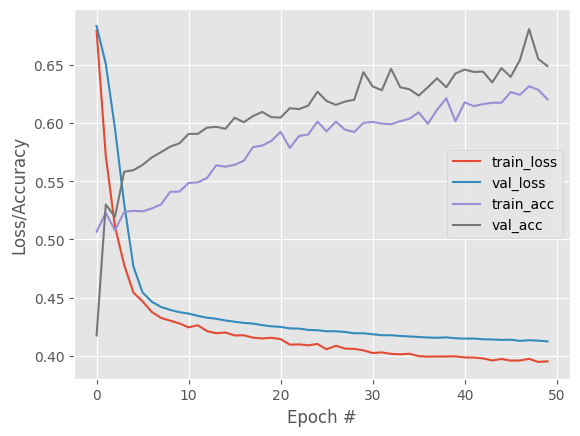

In [47]:
import matplotlib
# Графики потерь и точности
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Проверка на выборке

<Figure size 640x480 with 0 Axes>

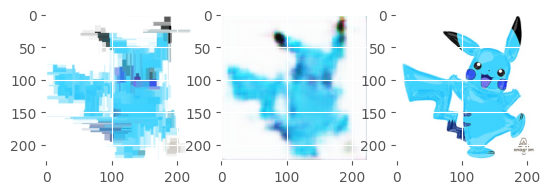

<Figure size 640x480 with 0 Axes>

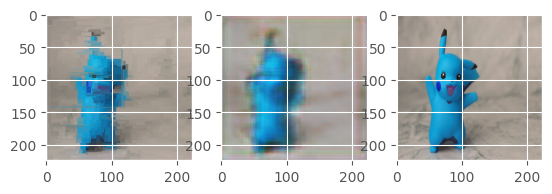

<Figure size 640x480 with 0 Axes>

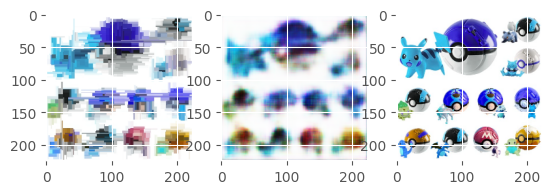

<Figure size 640x480 with 0 Axes>

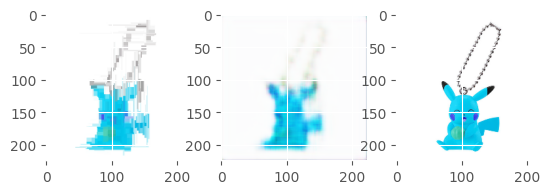

<Figure size 640x480 with 0 Axes>

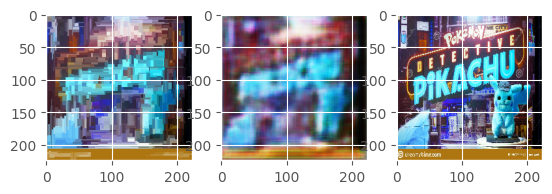

In [52]:


for i in range (5):
    val = x_test[i]
    val.shape
    val = val.reshape(-1, 224, 224, 3)
    pred = autoencoder.predict(val)

    fig = plt.figure()
    f, ax = plt.subplots(1,3) 
    ax[0].imshow(x_test[i])
    ax[1].imshow (pred[0])
    ax[2].imshow (y_test[i])
    plt.show()

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (аскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку. 

3. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого нужно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import numpy as np
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential, Model
from imutils import paths
from os import walk
from sklearn.model_selection import train_test_split

In [5]:
input = layers.Input(shape=(256, 256, 3)) 

e_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input)
pool1 = layers.MaxPooling2D((2, 2), padding='same')(e_conv1)
batchnorm_1 = layers.BatchNormalization()(pool1)

e_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
pool2 = layers.MaxPooling2D((2, 2), padding='same')(e_conv2)
batchnorm_2 = layers.BatchNormalization()(pool2)

e_conv3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
h = layers.MaxPooling2D((2, 2), padding='same')(e_conv3)

d_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(h)
up1 = layers.UpSampling2D((2, 2))(d_conv1)

d_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = layers.UpSampling2D((2, 2))(d_conv2)

d_conv3 = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(up2)
up3 = layers.UpSampling2D((2, 2))(d_conv3)

d_conv4 = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(up3)
up4 = layers.UpSampling2D((2, 2))(d_conv4)

r = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up4)

autoencoder_3 = Model(input, r)
autoencoder_3.compile(optimizer=Adam(learning_rate=0.0005), loss=['binary_crossentropy'], metrics=['accuracy'] )
autoencoder_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128   

In [6]:
x = []
y = []
f = []
mypath = './2/pickachu/'

for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

for filename in filenames[::3]:

    
    image = cv2.imread('./2/pickachu/{}'.format(filename))
    image_1  = image

    image = cv2.resize(image, (512, 512)) 
    y.append(image)

    image_1 = cv2.resize(image_1, (256, 256)) 
    x.append(image_1)

x = np.array(x, dtype="float") / 255.0
y = np.array(y, dtype="float") / 255.0


In [7]:
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.25, random_state=42)


print('Train: X = ', x_train.shape)
print('Test: X = ', x_test.shape)

Train: X =  (251, 256, 256, 3)
Test: X =  (84, 256, 256, 3)


In [8]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.0001)

filepath = "Res_model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]

In [9]:
history = autoencoder_3.fit(
    x_train, y_train,
    batch_size=2,
    epochs=50,
    verbose=1,
    validation_data=(x_test,y_test),
    callbacks = model_callbacks
    )

Epoch 1/50
126/126 [==============================] - 13s 33ms/step - loss: 0.4984 - accuracy: 0.5227 - val_loss: 0.6017 - val_accuracy: 0.4640
Epoch 2/50
126/126 [==============================] - 3s 23ms/step - loss: 0.4350 - accuracy: 0.5533 - val_loss: 0.5257 - val_accuracy: 0.4872
Epoch 3/50
126/126 [==============================] - 3s 23ms/step - loss: 0.4204 - accuracy: 0.5520 - val_loss: 0.4341 - val_accuracy: 0.5997
Epoch 4/50
126/126 [==============================] - 3s 23ms/step - loss: 0.4115 - accuracy: 0.5783 - val_loss: 0.4163 - val_accuracy: 0.5854
Epoch 5/50
126/126 [==============================] - 3s 23ms/step - loss: 0.4020 - accuracy: 0.5596 - val_loss: 0.4266 - val_accuracy: 0.6044
Epoch 6/50
126/126 [==============================] - 3s 23ms/step - loss: 0.4046 - accuracy: 0.5978 - val_loss: 0.4235 - val_accuracy: 0.6161
Epoch 7/50
126/126 [==============================] - 3s 23ms/step - loss: 0.3984 - accuracy: 0.5716 - val_loss: 0.4008 - val_accuracy: 0.685

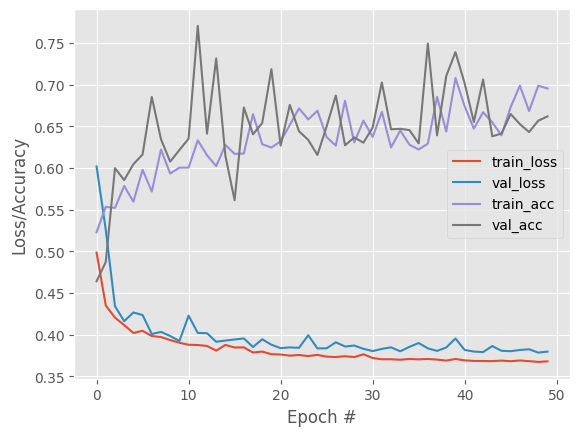

In [11]:
import matplotlib
# Графики потерь и точности
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

<Figure size 640x480 with 0 Axes>

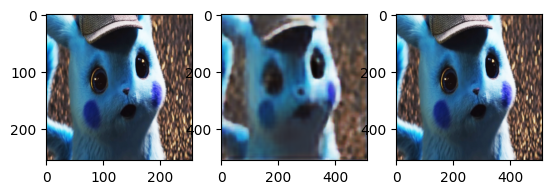

<Figure size 640x480 with 0 Axes>

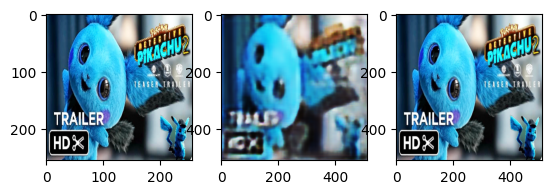

<Figure size 640x480 with 0 Axes>

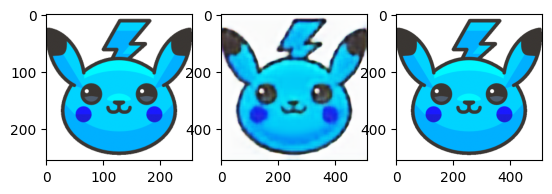

<Figure size 640x480 with 0 Axes>

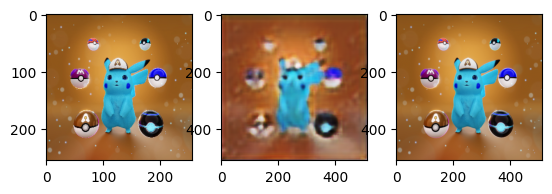

<Figure size 640x480 with 0 Axes>

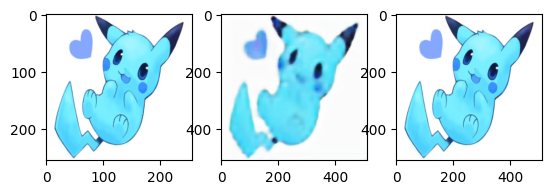

In [10]:
for i in range (5):
    val = x_test[i]
    val.shape
    val = val.reshape(-1, 256, 256, 3)
    pred = autoencoder_3.predict(val)

    fig = plt.figure()
    f, ax = plt.subplots(1,3) 
    ax[0].imshow(x_test[i])
    ax[1].imshow (pred[0])
    ax[2].imshow (y_test[i])
    plt.show()